# Modelling Neurons 

- How to construct a **Single Compartmental Electrical Model** 
- How to **Record the Membrane Voltage** and **Inject External Current**
- **Add Ion Channels** to the cell membrane
- Model a **Dendrite** 
- Model a **Synapse** 

For more information [NEURON Documentation](https://www.neuron.yale.edu/neuron/docs) 

HOCObject called with 'h' property (currently not supported without license) 

[Human Brain Project](https://collab.humanbrainproject.eu/#/collab/65449/nav/444850) Collaboration Link to run simulations with NEURON

In [ ]:
import os
os.unsetenv('PYTHONHOME')

!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

%matplotlib inline 

In [ ]:
import neuron 

In [ ]:
print neuron.h
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

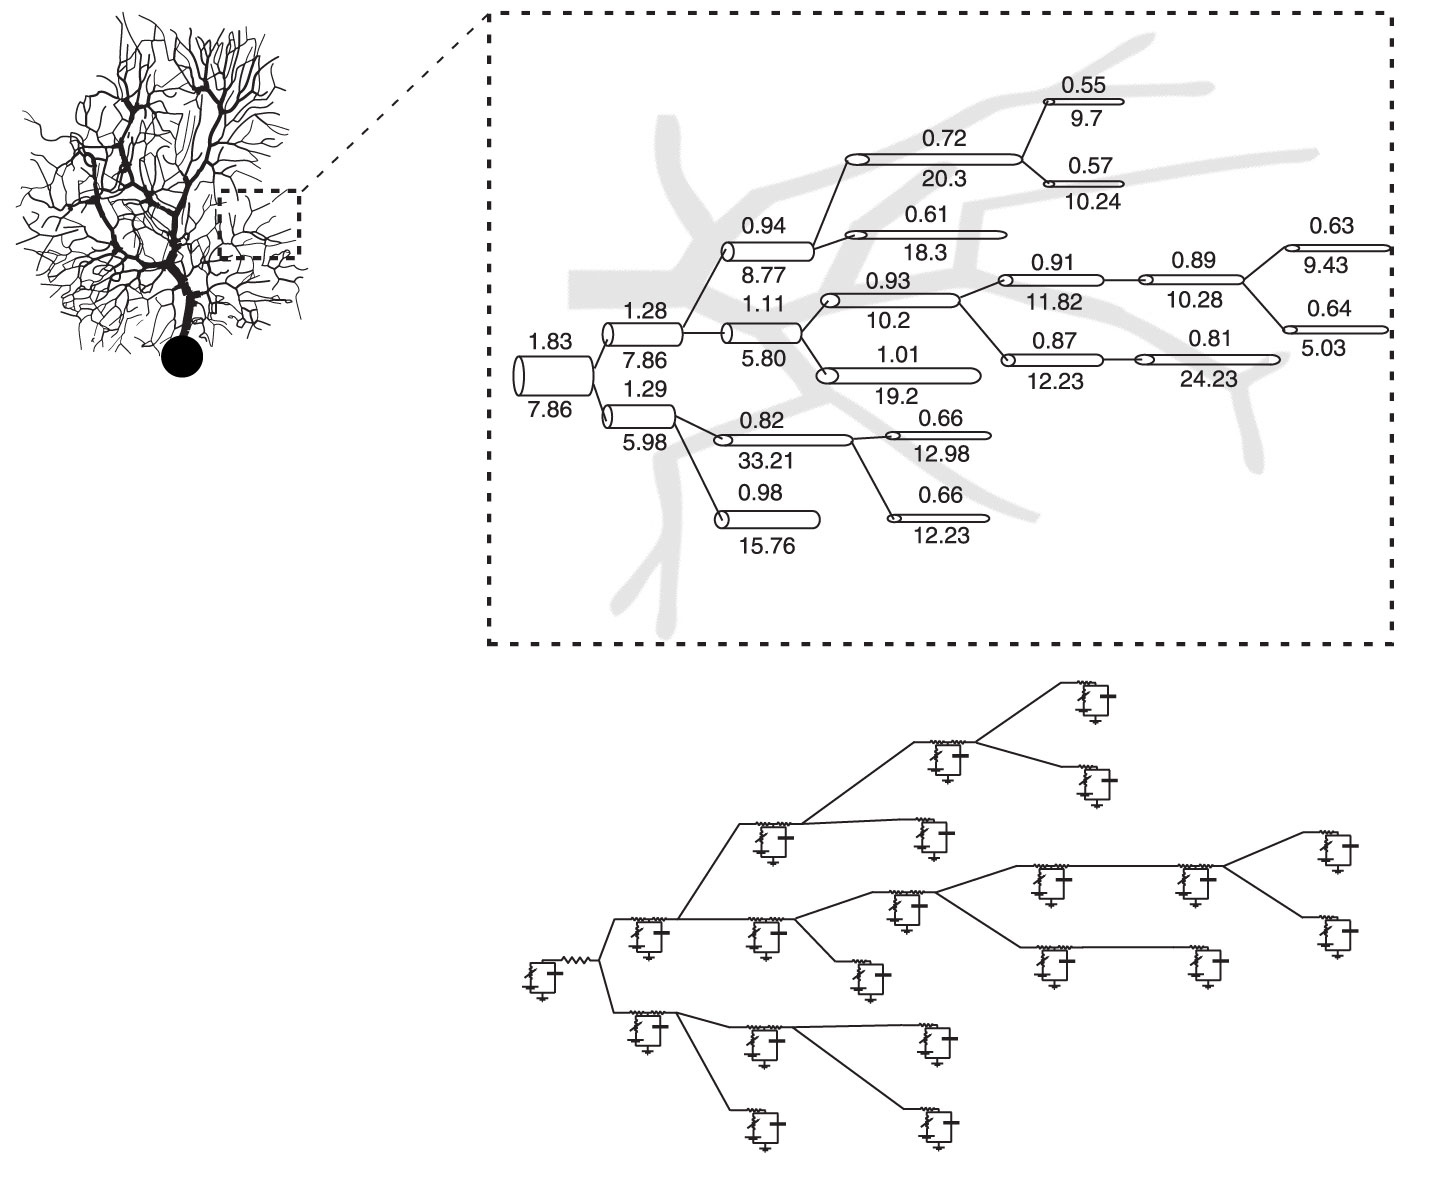

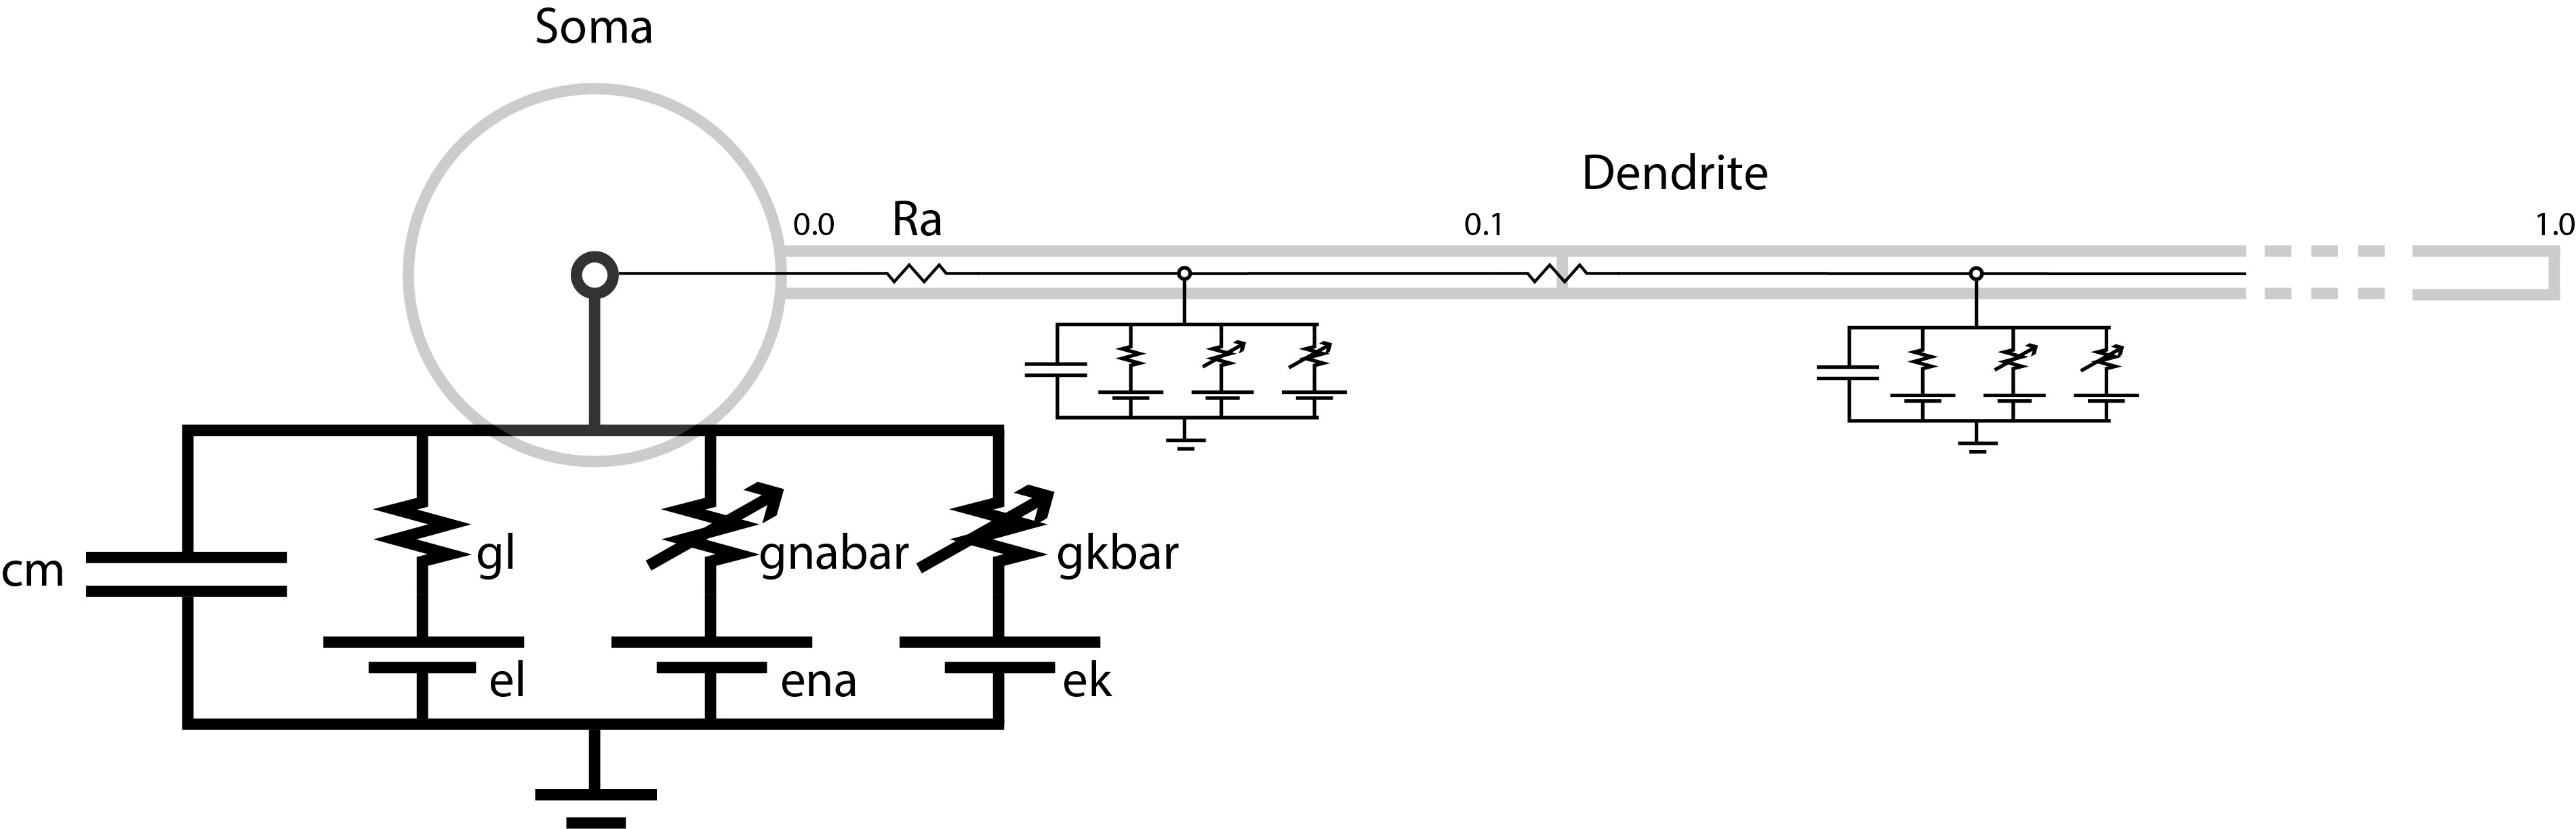
*Ball and stick model*
[Credits](https://mitpress.mit.edu/books/computational-modeling-methods-neuroscientists)

# Modelling the Soma

In [ ]:
#creating the soma of the neuron

soma = neuron.h.Section(name='soma')

print "Soma object:", soma
print "Soma object name: ", soma.name()

print "Number of segments in the soma:", soma.nseg

In [ ]:
#set the length and diameter of the soma
soma.L = 40
soma.diam = 40
print "Soma length: %f micron" % soma.L 
print "Soma diameter: %f micron" % soma.diam

In [ ]:
#calculate the surface area of the soma according to the cylinder surface area
#0.5 refers to the segment of the soma

soma_area_eq = 2 * neuron.h.PI * soma.L * soma.diam / 2
print "Soma area according to cylinder surface area equation: %f micron^2" % soma_area_eq

soma_area = neuron.h.area(0.5, sec=soma)
print "Soma area according to NEURON: %f micron^2" % soma_area

print "Both values match: %s" % (soma_area_eq == soma_area)

In [ ]:
soma_sphere_area_eq = 4 * neuron.h.PI * pow(soma.diam / 2, 2)
print "Soma area according to sphere surface area equation: %f micron^2" % soma_sphere_area_eq

### Calculate the Soma Capacitance

In [ ]:
#retrieve or set the membrane capacitance expressed in units of uf/cm^2

print "Specific capacitance: %f uf/cm2" % soma.cm

In [ ]:
#total soma capacitance = multiply by surface area in uf

soma_tcap = (soma.cm * (soma_area / pow(1e4, 2)))
print "Total soma capacitance: %f uf" % (soma.cm * (soma_area / pow(1e4, 2)))

# Run the Simulation

##### Record the membrne voltage in the middle of the soma

In [ ]:
print "Membrane voltage soma: %f mV" % soma(.5).v 

#expressed in mV

In [ ]:
#current time (t) expressed in ms
#the simulation will run until a predefined time 'tstop' variable
#every time step (dt) a new voltage will be calculated

print "Current time: %f ms" % neuron.h.t

In [ ]:
neuron.h.tstop = 100
print "Simulation stop time: %f ms" % neuron.h.tstop
print "Integration time step: %f ms" % neuron.h.dt

###### Record Time and Voltage

In [ ]:
#create two NEURON vector objects a) time and b) voltage

time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

In [ ]:
neuron.h.run()

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
    
plot_tv(time, voltage)

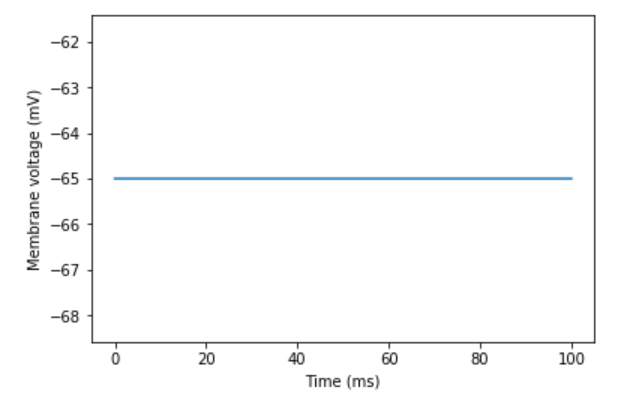

*Voltage has stayed the same overtime*

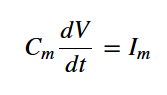

The changes in voltage are related to the current flowing across the membrane
I*m* = 0 and voltage remains the same

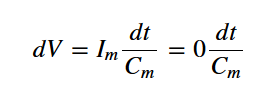

# Inject a Current

Change the cell membrane capacitance using current clamp

In [ ]:
#amplitude (nA), delay (ms), duration of stimulus (ms)

iclamp = neuron.h.IClamp(.5, sec=soma)
iclamp.amp = 0.1 # nA
iclamp.delay = 10 # ms
iclamp.dur = 50 # ms

In [ ]:
neuron.h.run()

plot_tv(time, voltage)

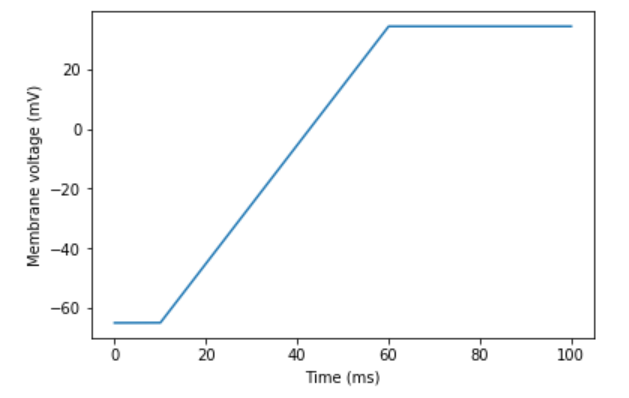

In [ ]:
V1 = -65              # Voltage before stimulus, mV
V2 = soma.v           # Voltage after stimulus, mV
deltaV = V2 - V1      # Voltage difference, mV
Im = iclamp.amp       # nA
deltaT = iclamp.dur   # ms
soma_tcap             # total soma membrane capacitance, uF

deltaV_eq = Im * deltaT / soma_tcap # in nA * ms / uF == microvolt
deltaV_eq /= 1e3                    # Correction factor to get mV

print 'Observed dV: %f mV' % deltaV
print 'Calculated dV: %f mV' % deltaV_eq
print 'Simulated dV matches equation dV: %s' % (deltaV - deltaV_eq < 1e-6)

# Add a Leak Conductance

Add transmembrane currents using the Hodgkin - Huxley Model

In [ ]:
#insert the hh mechanism in the soma

soma.insert('hh');

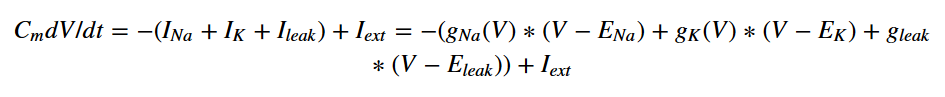

Na and K currents with voltage-dependent conductances  
Leakage current with a voltage-independent conductance

In [ ]:
#set Na and K conductance to 0

soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

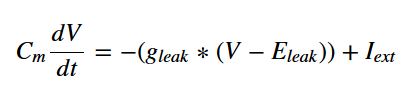

In [ ]:
#leak conductance set using 'gl_hh' attribute to set the reversal potential (leak current changes polarity)

soma.gl_hh = 5e-4 # Leak conductance, S/cm^2

In [ ]:
#set current close to the resting membrane potential -65mV

el = soma.el_hh = -65 
print "Reveral of leak current: %f mV" % el

In [ ]:
soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

neuron.h.tstop = 100

neuron.h.run()

plot_tv(time, voltage)

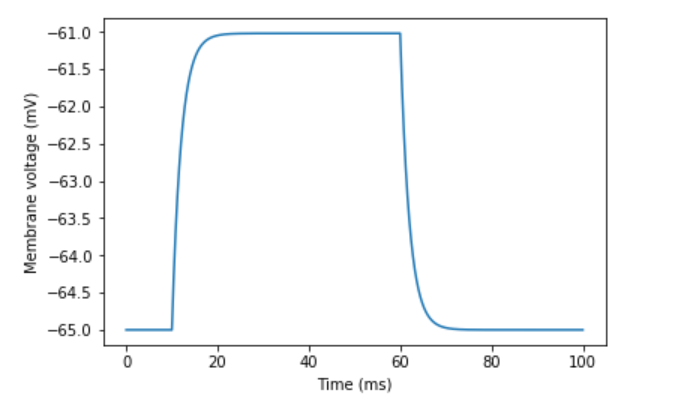

# Add Active Ion Channels

Active voltage-dependent ion channels of the Hodgkin-Huxley Model

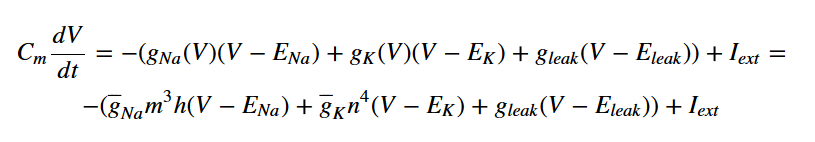

In [ ]:
#parameters expressed in Siemens/cm^2 and represent the density of the ion channels 

soma.gkbar_hh = 0.01 # in S/cm^2
soma.gnabar_hh = 0.1

neuron.h.run()

plot_tv(time, voltage)

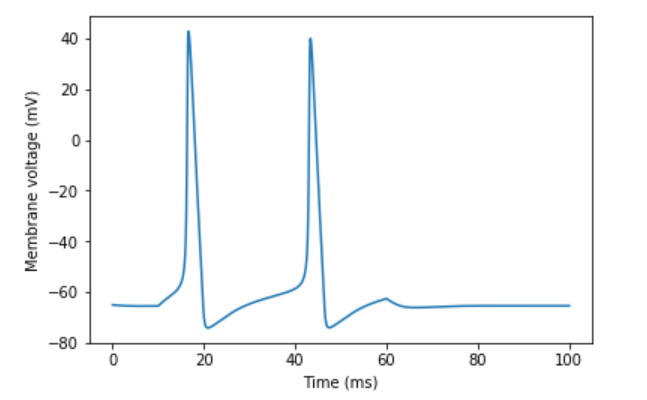

In [ ]:
#reversal potentials for Na and K

ena = soma.ena 
ek = soma.ek
el = soma.el_hh

print "Na reversal: %f" % ena
print "K reversal: %f" % ek
print "Leak reversal: %f" % el

plot_tv(time, voltage, constants=[ena, ek, el])

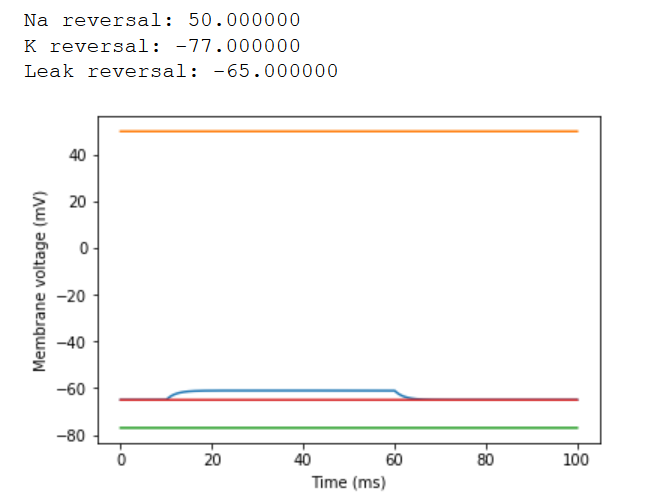

During an action potential the positive E*Na* gets the membrane potential close to 50mV. When it gets inactivated E*K* gets the membrane potential close to -77mV 

### Parametere Sensitivity 

Changing some of the parameters

In [ ]:
import matplotlib.pyplot as plt
import numpy

for gnabar in [0.1, 0.15]:
    soma.gkbar_hh = 0.01
    soma.gnabar_hh = gnabar

    neuron.h.tstop=30

    neuron.h.run()

    plt.plot(time, max(voltage)*numpy.ones(len(time)), 'r')
    plot_tv(time, voltage, show=False)

plt.show()

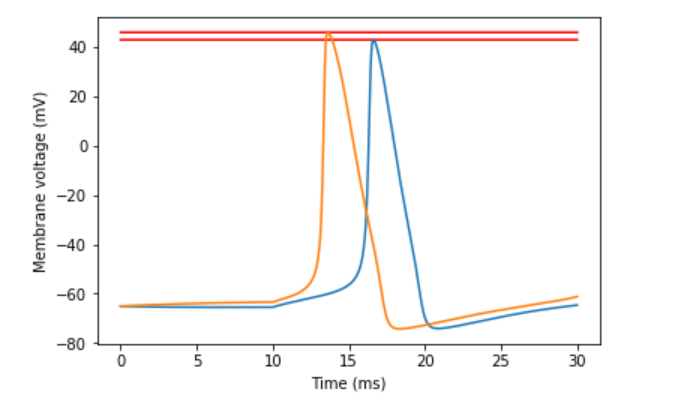

In [ ]:
soma.gkbar_hh = 0.01

max_voltages = []
import numpy
gnabar_range = numpy.arange(.05, 0.2, 0.001)
for gnabar in gnabar_range:
    soma.gnabar_hh = gnabar

    neuron.h.run()

    max_voltages.append(max(voltage))

plt.plot(gnabar_range, max_voltages, 'oC0')
plt.xlabel('gnabar (S/cm2)')
plt.ylabel('Maximum AP voltage')
for xs in [0.1, 0.15]:
    plt.axvline(x=xs, color='r')
plt.show()

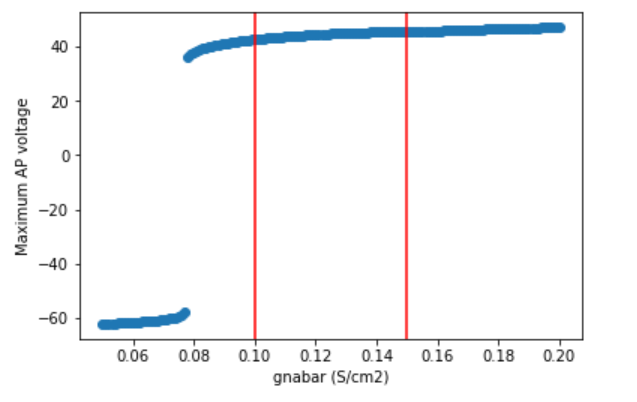

Around 0.08 S/cm^2 there is discontinuity, it represent the point at which the neuron starts firing APs

# Model a Dendrite

Connected with the soma

In [ ]:
dend = neuron.h.Section(name='dend')

dend.connect(soma)

dend.L = 400    # micron
dend.diam = 2.0 # micron
dend.nseg = 9   # number of segments in the dendritic section

In [ ]:
#passive hh mechanism meaning that K and Na channels are disabled

dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2

dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0

In [ ]:
for with_dend in [False, True]:
    neuron.h.tstop = 100

    soma.gkbar_hh = 0.01
    soma.gnabar_hh = 0.1

    if with_dend:
        dend.connect(soma)
    else:
        neuron.h.disconnect(sec=dend) # disconnect dend for now
        
    neuron.h.run()

    plot_tv(time, voltage, show=False, label='with dend' if with_dend else 'without dend')

plt.legend()
plt.show()

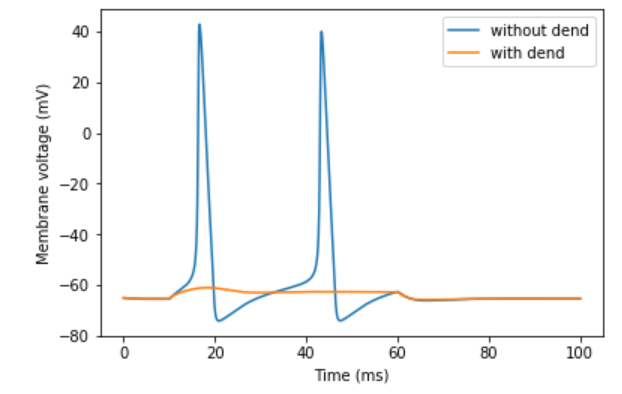

## Voltage attenuation along the dendrite

The height of the action potential will be attenuated while travelling across the dendrite

In [ ]:
#plot the voltage at different locations along the dendrite

dend.Ra = 200
dend.gl_hh = 5e-4

voltage_dend = {}

# distances are in percentage of dendritic length
# 1.0 is at end of dendrite, 0.0 at connection with soma
distance_range = numpy.arange(0, 1.1, 0.1)
for distance in distance_range:
    voltage_dend[distance] = neuron.h.Vector()
    voltage_dend[distance].record(dend(distance)._ref_v);
 
neuron.h.tstop = 40
neuron.h.run()

for distance in distance_range:
    plot_tv(time, voltage_dend[distance], show=False, label='%.0f%% of dend length' % (distance*100))
    
plt.legend()
plt.show()

max_voltage_dend = []
for distance in distance_range:
    max_voltage_dend.append(max(voltage_dend[distance]))

plt.plot(distance_range*100, max_voltage_dend, 'o')
plt.xlabel('percentage of dend length')
plt.ylabel('Max voltage (mV)')
plt.show()

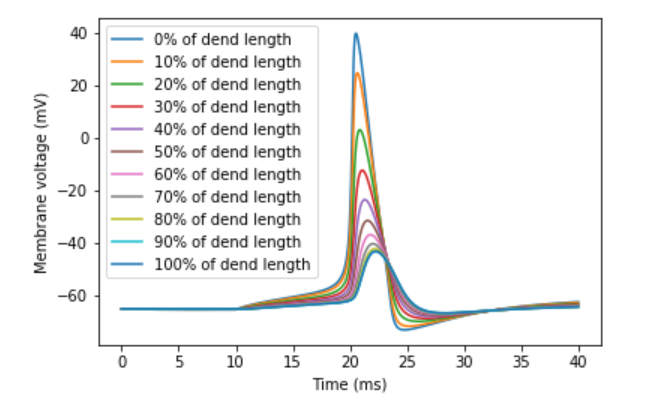

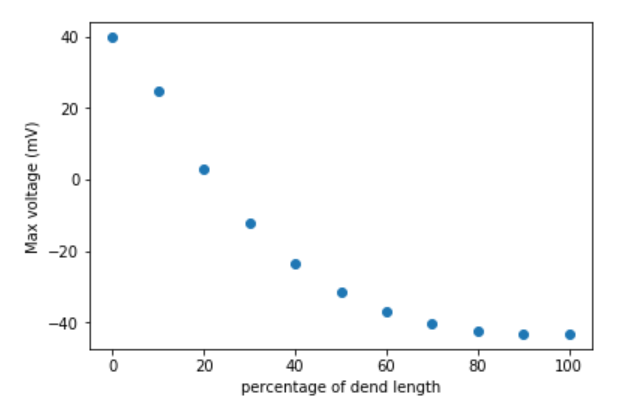

# Model a Synapse 

In NEURON a synapse is represented as a point process, located at a specific location 
Built-in synapse ExpSyn = synapse with a single exponential decay of its conductance

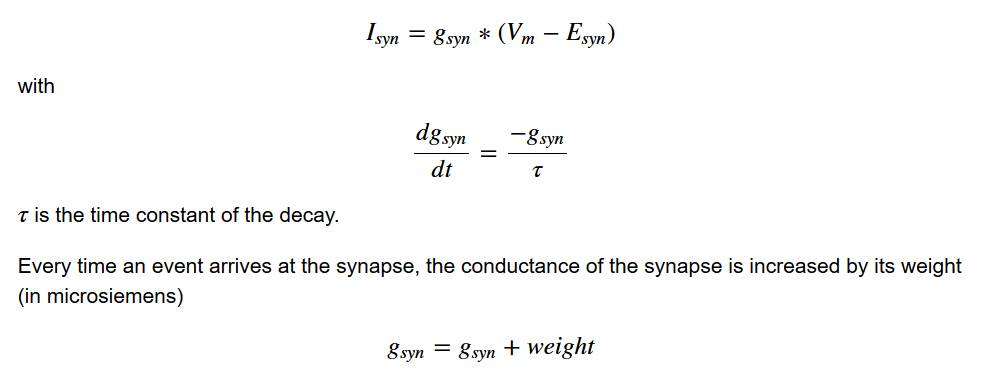

In [ ]:
expsyn = neuron.h.ExpSyn(.5, sec=dend)

In [ ]:
#stimulate the synapse by creating a NetStim object (presynaptic cell)
#Attributes of object a) how many times we want to stimulate the synapse, b) interval, c) when to start
#Noise determines the stochasticity and 0 noise means regular firing

netstim = neuron.h.NetStim()
netstim.interval = 5
netstim.number = 5
netstim.start = 20
netstim.noise = 0

In [ ]:
#the NetCon object acts as a connector between a pre-synaptic and a post-synaptic cell

netcon = neuron.h.NetCon(netstim, expsyn)
netcon.weight[0] = 1.0

In [ ]:
iclamp.amp = 0
neuron.h.tstop = 80
neuron.h.run()

plot_tv(time, voltage)

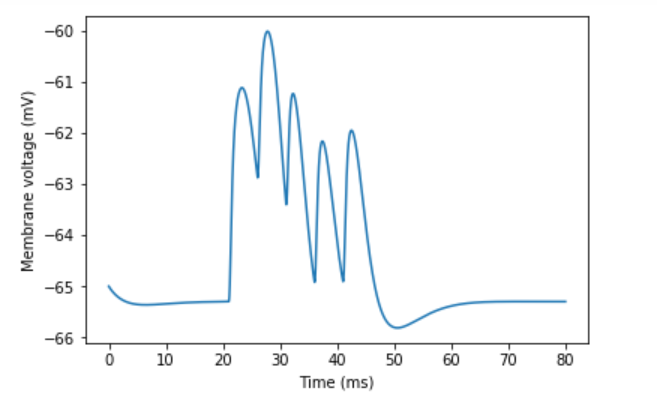

Each event injects a certain current in the cell, and slowly decays afterwards. When synaptic events occur in quick success they sum up.

In [ ]:
soma_pre = neuron.h.Section(name='soma')
soma_pre.L = 40
soma_pre.diam = 40
soma_pre.insert('hh')

iclamp_pre = neuron.h.IClamp(.5, sec=soma_pre)
iclamp_pre.amp = 1.0 # nA
iclamp_pre.delay = 10 # ms
iclamp_pre.dur = 50 # ms

time_pre = neuron.h.Vector()
voltage_pre = neuron.h.Vector()

time_pre.record(neuron.h._ref_t)
voltage_pre.record(soma_pre(.5)._ref_v);

expsyn.tau = .9
netcon_pre = neuron.h.NetCon(soma_pre(.5)._ref_v, expsyn, sec=soma_pre)
netcon_pre.weight[0] = 1

if 'netstim' in locals():
    del netstim
if 'netcon' in locals():
    del netcon

neuron.h.run()

time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_pre, voltage_pre, show=False, label='presynaptic')
plot_tv(time, voltage, show=False, label='postsynaptic')
plt.legend()
plt.show()

del netcon_pre

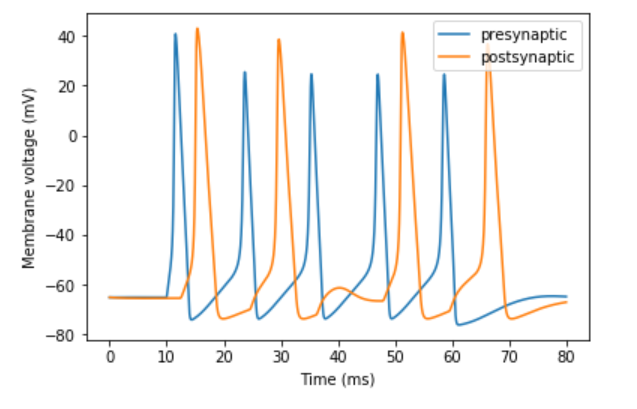

In [ ]:
#model synapse using Exp2Syn

import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

In [ ]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

In [ ]:
#create a double exponential synapse
#rise time τ = 1
#decay time τ = 2

synapse = h.Exp2Syn(soma(0.5))
synapse.tau1 = 0.5 # [ms]
synapse.tau2 = 10.0 # [ms]
synapse.e = -80.0 

In [ ]:
#define the stimulus = 8 spikes at 20Hz + 1 spike 500ms later

stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 0.001        # [uS]

In [ ]:
#Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

In [ ]:
h.tstop = 1000.0 
neuron.h.run()

In [ ]:
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()

In [ ]:
def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp


plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

plt.plot(time, connection.weight[0]*dual_exp(time, synapse.tau1, synapse.tau2, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

In [ ]:
#plot the voltage for the synaptic conductance events

plot_timecourse(time, v_soma)

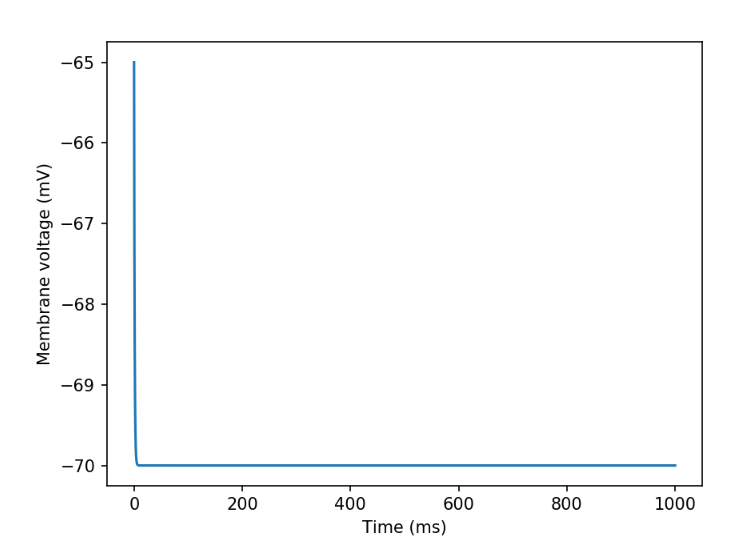

# The AMPA-NMDA Synapse Model

Download MOD files and compile them with NMODL

In [ ]:
import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

In [ ]:
synapse = h.SimpleAMPA_NMDA(soma(0.5))

stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0

g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

In [ ]:
#zero the NMDA conductance 

h.tstop = 1000.0 # ms
synapse.gmax_NMDA = 0.0
synapse.gmax_AMPA = 0.001 # uS
neuron.h.run()

In [ ]:
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()
        
plot_timecourse(time, v_soma)

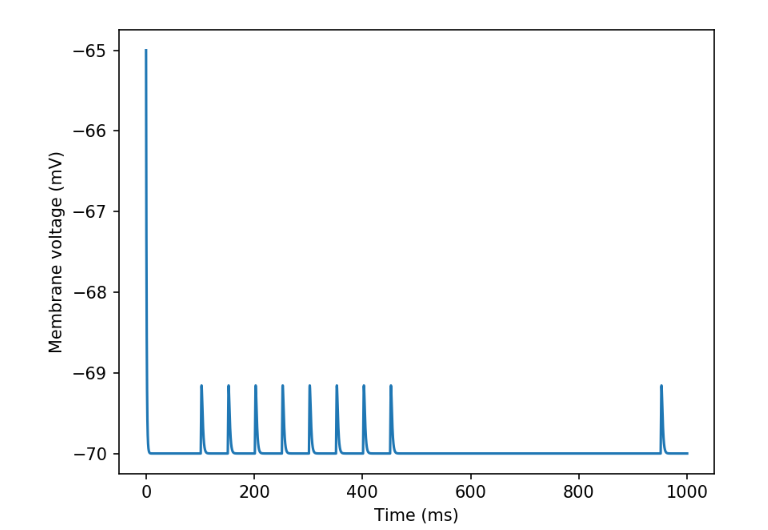

In [ ]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp
    
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_AMPA, synapse.tau_d_AMPA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

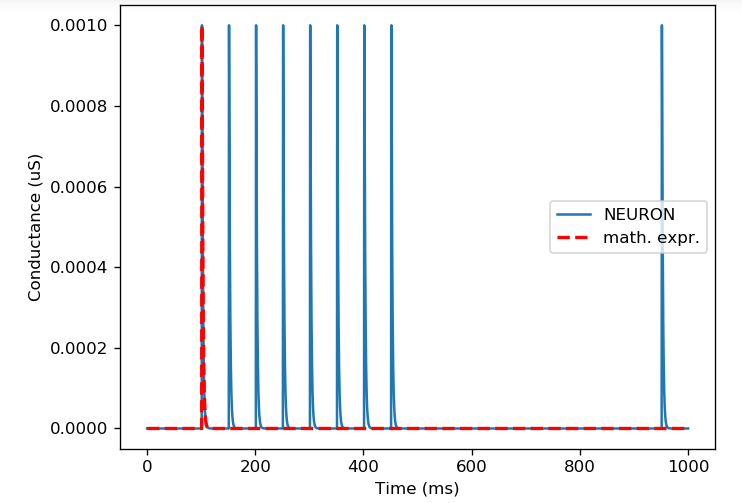

In [ ]:
#remove Mg block by zeroing the Mg concentration

synapse.gmax_NMDA = 0.001 # uS
synapse.mg = 0.0 # mM
synapse.gmax_AMPA = 0 # uS
neuron.h.run()

In [ ]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_NMDA, synapse.tau_d_NMDA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

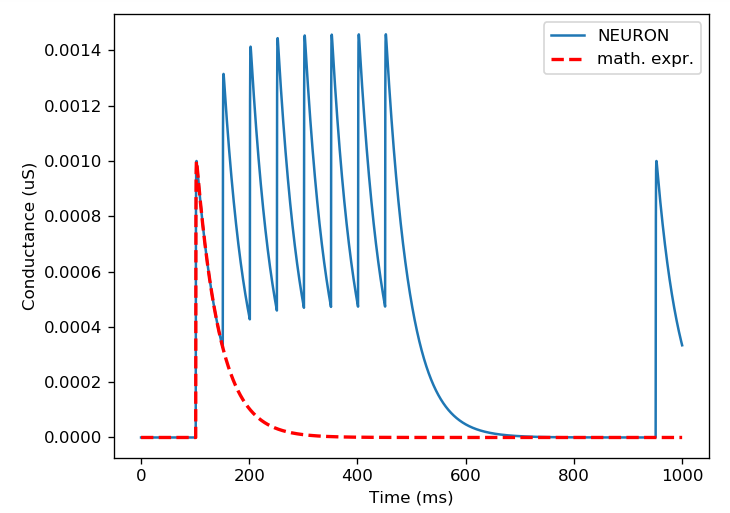

In [ ]:
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)
neuron.h.run()

In [ ]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON - g")
plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="NEURON - g_NMDA", newfigure=False)
plot_timecourse(time, g_AMPA, ylabel="Conductance (uS)", label="NEURON - g_AMPA", newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()

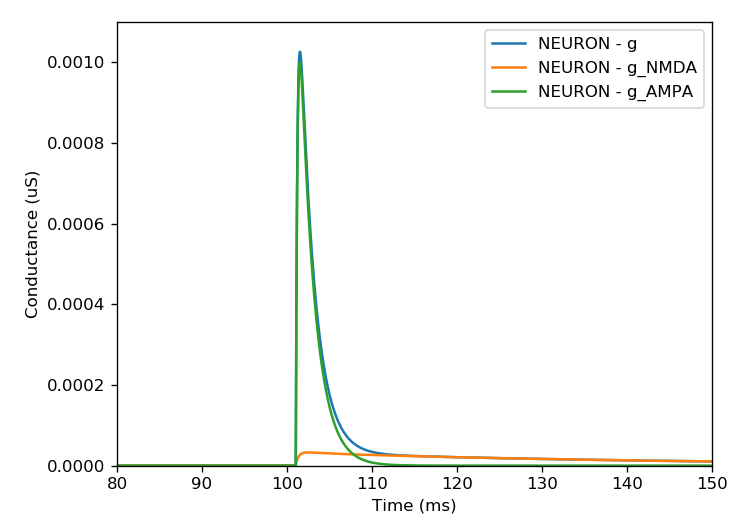

In [ ]:
#dependence of NMDA conductance on Magnesium concentration

g_NMDA_1mM = numpy.zeros_like(g_NMDA)
g_NMDA_1mM[:] = g_NMDA

plot_timecourse(time, g_NMDA_1mM, ylabel="Conductance (uS)", label="[Mg2+] = 1mM")
mgs = [0.5, 0.25, 0.1, 0.0]
for mg in mgs:
    synapse.mg = mg
    neuron.h.run()
    plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="[Mg2+] = %fmM" % mg, newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()

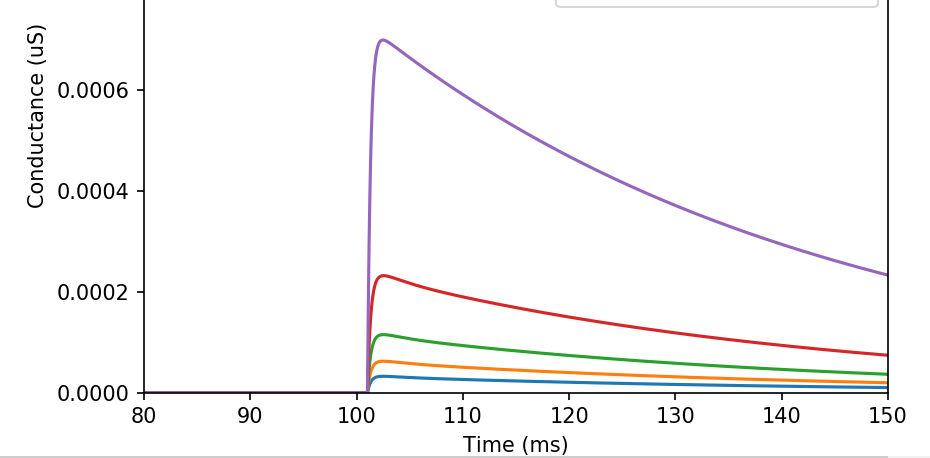

NMDA receptor requires the presence of Mg2+ for the voltage block to be effective

### Voltage block curve

NMDA for [Mg2+]=1.0

In [ ]:
#block the AMPA component of the conductance 

synapse.mg = 1.0
synapse.gmax_AMPA

In [ ]:
#voltage clamp the soma at a given holding voltage

voltage_clamp = h.VClamp(0.5, sec=soma) 
voltage_clamp.amp[0] = -80.0 
voltage_clamp.dur[0] = h.tstop

In [ ]:
def extract_peaks(time, trace, event_times, window=10):
    """
    Computes the peak between event_times and returns the times of occurence and the maximums
    Useful for finding PSP or conductance peaks due to synaptic events.
    kwarg 'window' defines the time in ms after the event to consider when searching for the peak
    """
    
    peaks_list = []
    peaks_times_list = []
    for event_time in event_times:
        i_start = time.searchsorted(event_time)
        i_end = time.searchsorted(event_time+window)
        # find the index where the max occurs
        i_max = numpy.argmax(trace[i_start:i_end])
        # append the time and value at the max to the respective lists
        peaks_times_list.append(time[i_start:i_end][i_max])
        peaks_list.append(trace[i_start:i_end][i_max])
        
    return numpy.array(peaks_times_list), numpy.array(peaks_list)

In [ ]:
def gNMDApeak_for_vclamp(v_clamp, eventNth=0):
    """returns the peak g_NMDA of the "eventNth" synaptic event for a given holding voltage"""
    voltage_clamp.amp[0] = v_clamp # Assign the clamping voltage
    neuron.h.run() # Simulate!
    g_NMDA = numpy.array(g_syn) # Get the resulting conductance as a numpy array (its only NMDA: AMPA is blocked) 
    time_arr = numpy.array(time) # Convert time h.Vector to a numpy array for subsequent operations
    peak_times, peaks = extract_peaks(time_arr, numpy.array(g_NMDA), spike_times) # extract the peaks and times
    peak_times_idx = time_arr.searchsorted(peak_times) # find array index of peak times 
    return peaks[eventNth] # return the peak conductance of the eventNth peak

In [ ]:
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

synapse.gmax_AMPA = 0.001
synapse.gmax_NMDA = 0.7 * 0.001 
synapse.mg = 1.0 

In [ ]:
synapse.U1 = 0.2 # Baseline release probability
synapse.tau_rec = 200 # ms - recovery from depression
synapse.tau_facil = 200 # ms - relaxation from facilitation

h.tstop = 1000.0 # ms
neuron.h.run()

In [ ]:
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()
        
plot_timecourse(time, v_soma)
plt.axis([0, 1000, -70, -69.5])

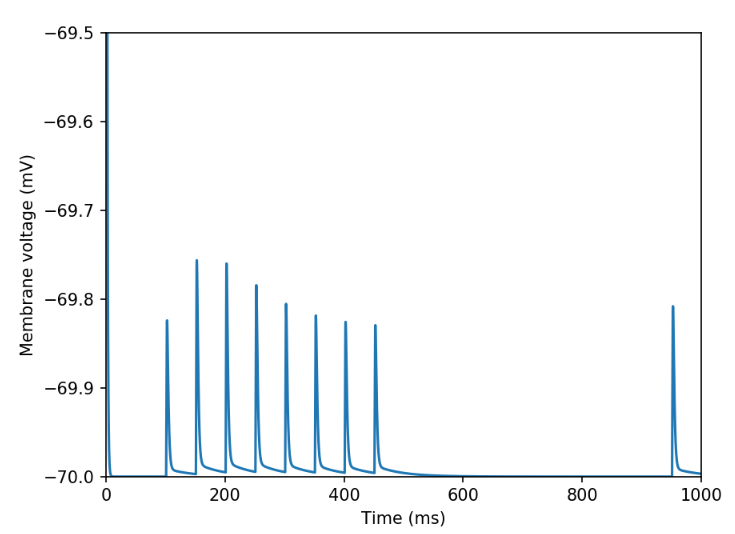

In [ ]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()

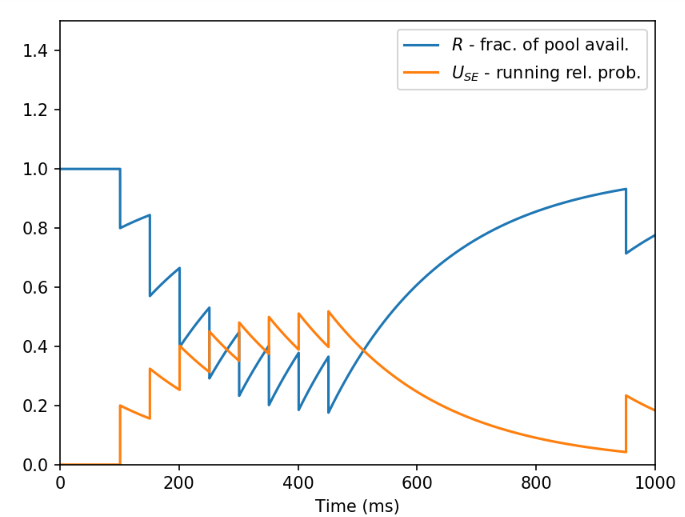

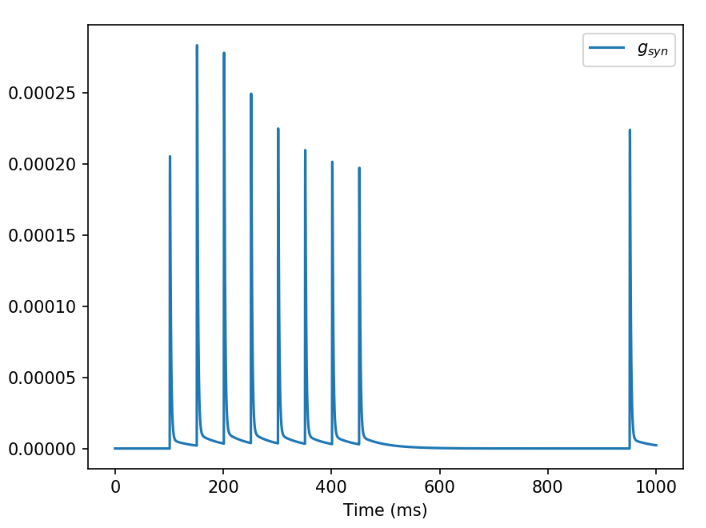